<a href="https://colab.research.google.com/github/signLangProjectNIC/tf-cnn-lstm4/blob/main/tf_cnn_lstm6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#here we have to take care of underfitting by increasing the model depth and complexity

In [2]:
#lets do something lets increase the number of lstm units and run the experiment using high dropout rates
'''
the basic motivation is to make the model BETTER for the data and the task
'''

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.4.1
Running on TPU  ['10.58.124.26:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.58.124.26:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.58.124.26:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import numpy as np
X=np.load("/content/gdrive/MyDrive/hand sign database array X.npy")
Y=np.load("/content/gdrive/MyDrive/hand sign database array Y.npy")

In [4]:
import tensorflow as tf
import tensorflow.keras.layers as tfKL
from keras.layers import Activation, Dense 
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import random
import pandas as pd

nLookback=4
height=50
width=50
channels=3
nCategories=8

In [5]:
def sameLists(l1,l2):
  i=0
  for li1 in l1:
    j=0
    for li2 in li1:
      change=l1[i][j]-l2[i][j]
      answer=np.count_nonzero(change)
      if answer>0:
        return False
      j+=1
    i+=1
  return True

In [6]:
def createModel(dropoutsRates=list((0.5,0.5,0.5)),nLSTMunits=200):
  with tpu_strategy.scope():
    model=tf.keras.Sequential()
    model.add(tfKL.TimeDistributed(tfKL.Conv2D(filters=64,kernel_size=(3,3),activation='relu',trainable=True),input_shape=(None,nLookback,height,width,channels)))
    model.add(tfKL.TimeDistributed(tfKL.Dropout(dropoutsRates[0],trainable=True)))
    model.add(tfKL.TimeDistributed(tfKL.Conv2D(filters=64,kernel_size=(3,3),activation='relu',trainable=True)))
    model.add(tfKL.TimeDistributed(tfKL.Dropout(dropoutsRates[1],trainable=True)))

    model.add(tfKL.TimeDistributed(tfKL.MaxPooling3D(pool_size=(2,2,2),trainable=True)))
    model.add(tfKL.TimeDistributed(tfKL.Flatten(trainable=True)))


    model.add(tfKL.LSTM(units=nLSTMunits,activation='tanh',trainable=True))
    model.add(tfKL.Dropout(dropoutsRates[2],trainable=True))
    model.add(tfKL.Dense(units=100,activation='relu',trainable=True))
    model.add(tfKL.Dense(units=nCategories,activation='softmax',trainable=True))
    model.compile(metrics=['accuracy'],loss='categorical_crossentropy',optimizer='adam')
    return model

In [11]:
def evaluateModel(X,Y,nSubsequences=5,nLookback=4,nCategories=8,train_size=0.8,verbose=0,epochs=30,val_prop=0.2223,dropoutsRates=list((0.5,0.5,0.5)),nLSTMunits=200):
  with tpu_strategy.scope():
    trainX, testX, trainY, testY = train_test_split(X, Y, train_size=train_size, random_state=random.randint(1,100000))
  
  verbose=verbose
  epochs=epochs
  batch_size=10

  
  height=trainX.shape[2]
  width=trainX.shape[3]
  channels=trainX.shape[4]
  trainX=trainX.reshape((trainX.shape[0],nSubsequences,nLookback,trainX.shape[2],trainX.shape[3],trainX.shape[4]))
  testX=testX.reshape((testX.shape[0],nSubsequences,nLookback,testX.shape[2],testX.shape[3],testX.shape[4]))
  trainY=tf.keras.utils.to_categorical(trainY)
  testY=tf.keras.utils.to_categorical(testY)
  accuracy=0
  model=createModel(dropoutsRates=dropoutsRates,nLSTMunits=nLSTMunits)
  with tpu_strategy.scope():
    history=model.fit(trainX,trainY,batch_size=batch_size,epochs=epochs,verbose=verbose,validation_split =val_prop)
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    _,accuracy=model.evaluate(testX,testY,verbose=0,batch_size=batch_size)
  return accuracy

In [12]:
def summarizeScores(scores):
  print("Scores: ",scores)
  m,s=np.mean(scores),np.std(scores)
  x=[i for i in range(np.shape(scores)[0])]
  plt.plot(x,scores)
  
  plt.xlabel('Run')
  plt.ylabel('Accuracy')
  
  plt.show()
  print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

In [13]:
def runExperiments(X,Y,train_size=0.8,run=10,epochs=30,verbose=0,val_prop=0.2223,dropoutsRates=list((0.5,0.5,0.5)),nLSTMunits=200):#weights are changing for each run in experiment we can transfer weights accross experiments too but we are not doing that right now
  scores=list()
  for r in range(run):
    score=evaluateModel(X=X,Y=Y,train_size=train_size,epochs=epochs,val_prop=val_prop,dropoutsRates=dropoutsRates,nLSTMunits=nLSTMunits)
    score*=100.0
    scores.append(score)
    print('>#%d: %.3f' % (r+1, score))
  summarizeScores(scores)
  print("--------------------------------------------------------------------------------------------------------------------------")

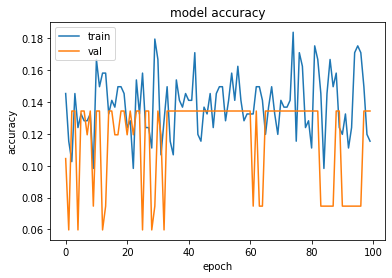

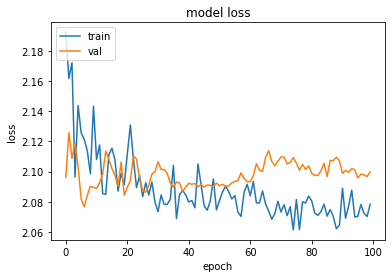

>#1: 7.921


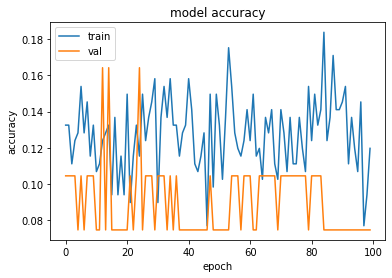

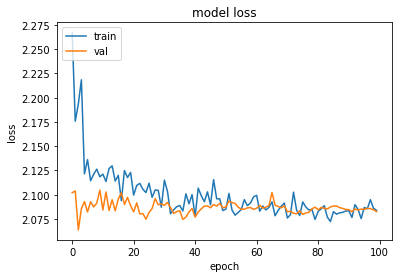

>#2: 14.851


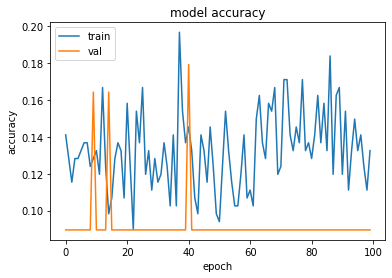

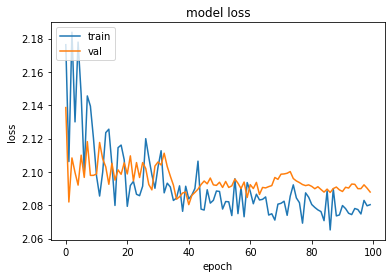

>#3: 9.901


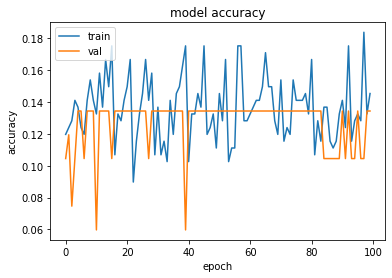

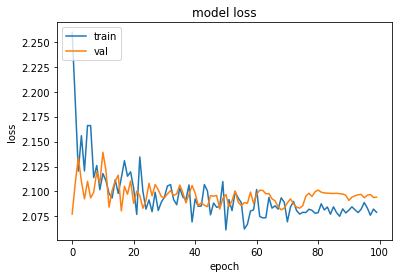

>#4: 7.921


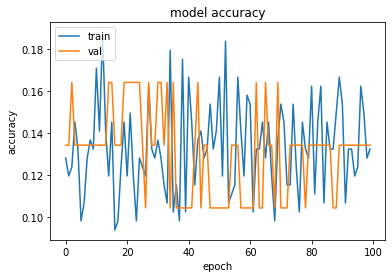

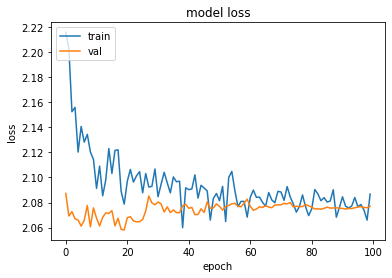

>#5: 9.901
Scores:  [7.920791953802109, 14.851485192775726, 9.90099012851715, 7.920791953802109, 9.90099012851715]


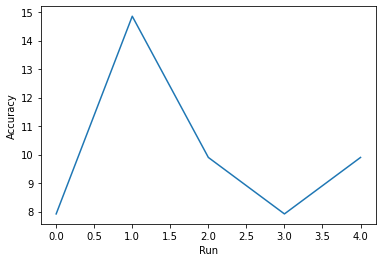

Accuracy: 10.099% (+/-2.536)
--------------------------------------------------------------------------------------------------------------------------
-------------------------------------------


KeyboardInterrupt: ignored

In [15]:
with tpu_strategy.scope():
  runExperiments(X,Y,train_size=0.75,run=5,epochs=100,dropoutsRates=list((0.5,0.5,0.5)),nLSTMunits=200)
  print("-------------------------------------------")
  runExperiments(X,Y,train_size=0.75,run=5,epochs=100,dropoutsRates=list((0.5,0.5,0.5)),nLSTMunits=100)
  print("-------------------------------------------")

In [ ]:
#clearly increasing the lstm units does not help. Lets try reducing it

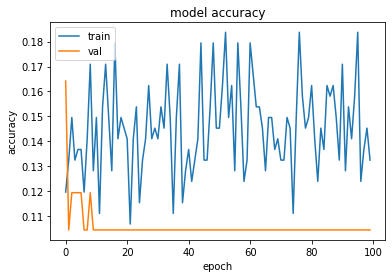

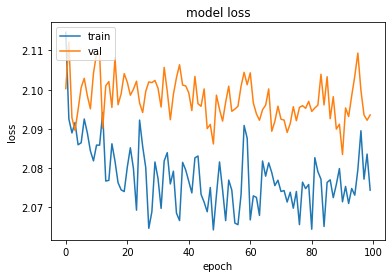

>#1: 8.911


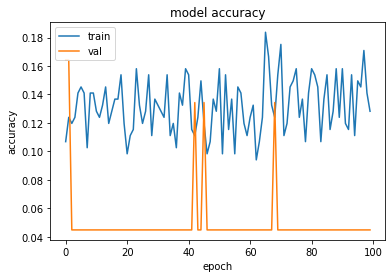

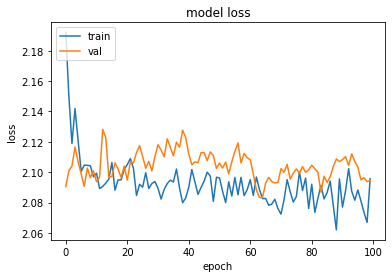

>#2: 13.861


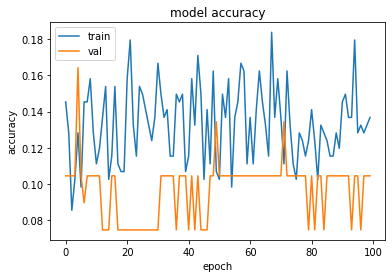

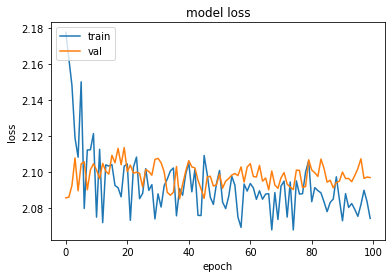

>#3: 10.891


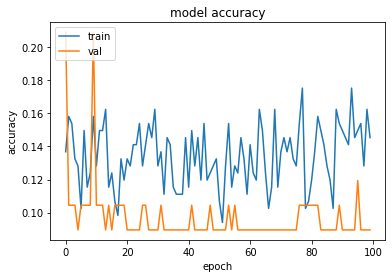

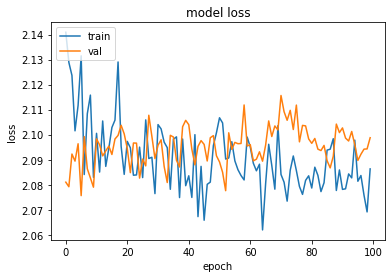

>#4: 11.881


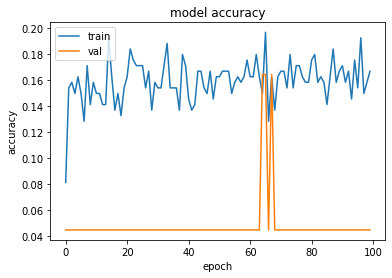

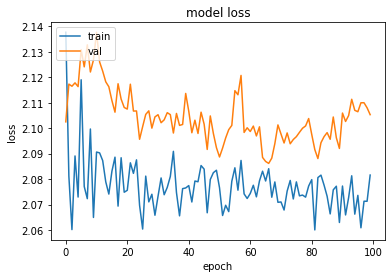

>#5: 8.911
Scores:  [8.9108906686306, 13.861386477947235, 10.891088843345642, 11.881187558174133, 8.9108906686306]


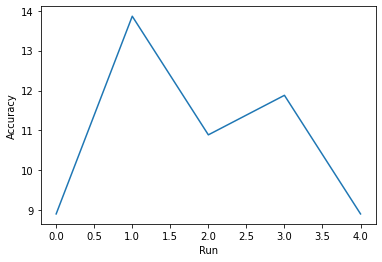

Accuracy: 10.891% (+/-1.879)
--------------------------------------------------------------------------------------------------------------------------
-------------------------------------------


In [16]:
with tpu_strategy.scope():
  runExperiments(X,Y,train_size=0.75,run=5,epochs=100,dropoutsRates=list((0.5,0.5,0.5)),nLSTMunits=50)
  print("-------------------------------------------")

In [17]:
#so it seems that comparing the values for nLSTMunits 100>200 and 100>50

In [ ]:
#lets then try to introduce a new LSTM layer altogether